# Определение тональности текста отзывов на фильмы из IMDb (Internet Movie Database) с помощью моделей нейронных сетей

Не забудьте подключить GPU, чтобы сеть обучалась быстрее

## Описание набора данных IMDb movie review


[Набор данных IMDb movie review](https://ai.stanford.edu/~amaas/data/sentiment/) создан для задач определения тональности текста. Набор включает отзывы на фильмы с сайта [IMDb](https://www.imdb.com). Отзывы только явно положительные (оценка >= 7) или отрицательные (оценка <= 4), нейтральные отзывы в набор данных не включались.

Размер набора данных 50 тыс. отзывов:
- Набор данных для обучения - 25 тыс. отзывов
- Набор данных для тестирования - 25 тыс. отзывов

Количество положительных и отрицательных отзывов одинаковое.

Разметка набора данных:
- 0 - отзыв отрицательный
- 1 - отзыв положительный

С точки зрения машинного обучения это задача бинарной классификации.

Набор данных описан в статье: [Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)] (https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, f1_score

from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences


from sklearn.metrics import classification_report, accuracy_score, f1_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Загрузка данных

Будем считать, что максимальное число слов будет равно 10000.

Мы здесь могли бы и не задавать максимальное число слов, тогда эта величина была бы определена автоматически при парсинге текста. Но данный параметр имеет один существенный плюс: из всех найденных слов мы оставляем 9999 наиболее часто встречаемых (max_words_count-1), то есть, отбрасываем редкие слова, которые особо не нужны при обучении НС. Этот параметр устанавливается с позиции «здравого смысла». Например, при большой обучающей выборке хорошим выбором будет значение в пределах:

max_words_count = 20000



In [ ]:
max_words_count=10000
max_review_len = 200

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words_count)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Выведем, например, первый отзыв обучающего набора данных
x_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [ ]:
# Его метка (номер класса)
y_train

array([1, 0, 0, ..., 0, 1, 0])

В наборе данных IMDB используется частотное кодирование слов (мешок слов). Загрузим словарь, который использовался для кодирования и раскодируем все отзывы.



In [ ]:
word_index = imdb.get_word_index()

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
word_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

Получили словарь с частотами каждого слова. Преобразуем словарь, чтобы по номеру получать слово

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
# Первые 20 самых часто встречающихся слов
for i in range(1, 21):
    print(i, '->', reverse_word_index[i])

1 -> the
2 -> and
3 -> a
4 -> of
5 -> to
6 -> is
7 -> br
8 -> in
9 -> it
10 -> i
11 -> this
12 -> that
13 -> was
14 -> as
15 -> for
16 -> with
17 -> movie
18 -> but
19 -> film
20 -> on


Теперь раскодируем сообщения обучающего набора данных

In [ ]:
def decode_review(text):
	return " ".join([reverse_word_index.get(i, "?") for i in text])

decode_review(x_train[0])

"the as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have t

In [ ]:
y_train[0]

1

Теперь, нам нужно выровнять все векторы до длины max_text_len. Для этого используется встроенный метод `pad_sequences`, который преобразует список (длиной `num_samples`) последовательностей (списков целых чисел) в двумерный массив NumPy формы (`num_samples, num_timesteps`).

`num_timesteps` — это либо `maxlen` аргумент, если он указан, либо длина самой длинной последовательности в списке.

Последовательности, которые короче `num_timesteps` дополняются `value` до тех пор, пока они не станут `num_timesteps` длинными.

Последовательности, длина которых больше `num_timesteps`, усекаются до желаемой длины.

Позиция, где происходит заполнение или усечение, определяется аргументами `padding` и `truncating` соответственно. Предварительное заполнение или удаление значений из начала последовательности является значением по умолчанию.

``` python
tf.keras.utils.pad_sequences(
    sequences,
    maxlen=None,
    dtype=&#x27;int32',
    padding=&#x27;pre',
    truncating=&#x27;pre',
    value=0.0
)
```

In [ ]:
x_train_pad_seq = pad_sequences(x_train, maxlen=max_review_len, padding='post')
x_test_pad_seq = pad_sequences(x_test, maxlen=max_review_len, padding='post')

In [ ]:
x_train_pad_seq[120]

array([   1,   14,   22,    9,   40,   35, 9865,    7,    4,    2,   12,
         47,  141, 1504, 4374,    5, 3093,   25,   70,   24,  869,  264,
         12,   16,   93,  103,    4,  182,  325,   54, 3169,   16,    2,
          5,    2,    5,   16, 1061,   19,    6,  666, 3276,    2, 3895,
         12,    9,    6,    2,    8,    4,  118, 2432,    7,    4,  406,
       1103,   17,   73,   17,    8,    4, 2203, 1518, 4697,    7,   15,
       1541,    7, 2867,   10,   10,    2,    9,    6,  109,   40,    2,
       2665,    6,  682, 2890, 1556,   27,   96,   11,    6,  194,  543,
         29,    9, 4187,    5,    2,    2,   34,  119,    5,   27, 1421,
        653,    4,   84,   29, 3267,   17,   76,   17,    4, 4631,  780,
          2,    4,   65,    9,  579,   11,    6, 1249, 1377,    5,  606,
        405,  246,    2,   19,    6, 1236,   15,    9,  220,    6,    2,
          7,    2,    2, 5389,   12,    9,   31,    7,    4,   91, 3373,
       5037,  102,  126,   93,    0,    0,    0,   

## Полносвязная нейронная сеть

Построим модель полносвязной НС:

* 1 скрытый слой - 128 нейронов;

* 2 скрытый слой - 64 нейрона;

* выходной слой - 1 нейрон.

В качестве функций активации скрытого слоя выберем популярную на сегодняшний день `ReLu`, а у выходных нейронов – `sigmoid`, т.к. мы хотим интерпретировать выходные значения в терминах вероятности принадлежности к классу 1.


Последовательность слоев задается классом `Sequential()`.

Полносвязный слой задается классом `Dense()`:
```python
Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None,
bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, lora_rank=None)

```
аргументы:
* `units` - целое положительное число в единицах измерения, размерность выходного пространства.
`activation` - используемая функция активации. Если вы ничего не укажете, активация не будет применена (т.е. "линейная" активация: a(x) = x).
* `use_bias` - логическое значение `use_bias` указывает, использует ли слой вектор смещения.
* `kernel_initializer` - инициализатор матрицы весов ядра.
* `bias_initializer` - инициализатор вектора смещения.
* `kernel_regularizer` - функция регуляризации, применяемая к матрице весов ядра.
* `bias_regularizer` - функция регуляризации, применяемая к вектору смещения.
* `activity_regularizer` - функция регуляризации, применяемая к выходным данным слоя (его "активации").
* `kernel_constraint` - функция ограничения, применяемая к матрице весов ядра.
* `bias_constraint` - функция ограничения , применяемая к вектору смещения.
* `lora_rank` - необязательное целое число. Если задано, при прямом переходе слоя будет реализован LoRa (адаптация низкого ранга) с указанным рангом. LoRa устанавливает для ядра слоя значение, не поддающееся обучению, и заменяет его значением дельта по сравнению с исходным ядром, полученным путем умножения двух обучаемых матриц более низкого ранга. Это может быть полезно для снижения вычислительных затрат при точной настройке больших плотных слоев. Вы также можете включить LoRa на существующем плотном слое, вызвав `layer.enable_lora(rank)`.

Для вывода архитектуры построенной модели используем метод `summary()`.

In [ ]:
model_dense = keras.Sequential([
                          Dense(units = 128, input_shape = (max_review_len,),  activation = 'relu'),
                          Dense(64, activation = 'relu'),
                          Dense(1, activation = 'sigmoid')
])


model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,049 (133.00 KB)

 Trainable params: 34,049 (133.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Изобразим архитектуру модели методом plot_model
#plot_model(model_dense, show_shapes = True, show_layer_activations = True)

Выберем функцию потерь (`loss function`) и способ оптимизации градиентного алгоритма `adam`. В задачах множественной классификации лучше всего начинать с бинарной кросс-энтропии в качестве функции потерь и активационной функции выходных нейронов `sigmoid`. Пусть целевой метрикой будет `accuracy`.

Компилируем модель

In [ ]:
model_dense.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Запустим обучение модели, используем метод `fit`. Результаты процесса обучения сохраним в переменную `hist_dense`. Для валидации выделим 20% обучающей выборки. Проведем обучение в течение 15 эпох, размер мини-батча установим равным 64.

Здесь появились новые параметры:

`batch_size` = 64 – это размер батча (64 слова), после которых будет выполняться корректировка весов;

`validation_split` = 0,2 – разбиение обучающей выборки на собственно обучающую и проверочную. Значение 0,2 определяет, что для каждой эпохи 20% случайных картинок из обучающей выборки будут помещаться в выборку валидации. 20% - это довольно частое значение для создания проверочной выборки (ее, как правило, выбирают из диапазона от 10% до 30%).

In [ ]:
hist_dense = model_dense.fit(x_train_pad_seq, y_train, batch_size = 64, epochs = 15, validation_split = 0.2)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4878 - loss: 169.4561 - val_accuracy: 0.5188 - val_loss: 16.8722
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5192 - loss: 11.5045 - val_accuracy: 0.5062 - val_loss: 6.9955
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5193 - loss: 6.0314 - val_accuracy: 0.5090 - val_loss: 3.2484
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5260 - loss: 4.2950 - val_accuracy: 0.5014 - val_loss: 3.3482
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5292 - loss: 2.8269 - val_accuracy: 0.5050 - val_loss: 3.4117
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5370 - loss: 2.9666 - val_accuracy: 0.4976 - val_loss: 2.4683
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5365 - loss: 2.8996 - val_accuracy: 0.5044 - val_loss: 2.9149
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5369 - loss: 2.1981 - val_accuracy

Построим кривые обучения

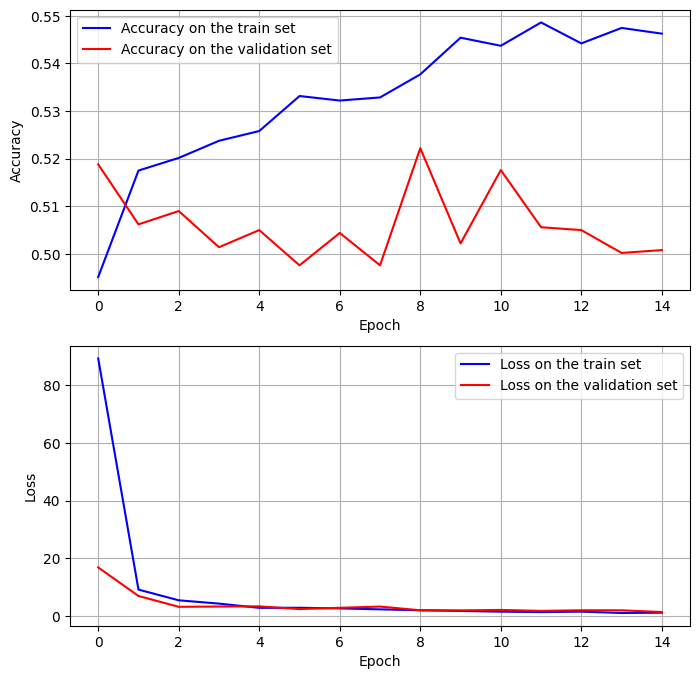

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_dense.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_dense.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_dense.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_dense.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Выполним проверку работы сети на тестовом множестве. Метод `evaluate` прогоняет все тестовое множество и вычисляет значение критерия качества и метрики.

In [ ]:
test_loss, test_accuracy = model_dense.evaluate(x_test_pad_seq, y_test)
print('Accuracy на тестовом наборе ', round(test_accuracy, 5))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5012 - loss: 1.5065
Accuracy на тестовом наборе  0.503


### Использование one-hot-encoding для представления текста

In [ ]:
# Функция для кодирования one-hot-encoding
def vectorize_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [ ]:
x_train_ohe = vectorize_sequences(x_train, max_words_count)
x_test_ohe = vectorize_sequences(x_test, max_words_count)

In [ ]:
x_train_ohe[0][:100]

array([0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])

Используем такую же архитектуру полносвязной нейронной сети для обучения на векторах `x_train_ohe`. Проведем обучение при тех же параметрах.

In [ ]:
model_dense_ohe = keras.Sequential([
                          Dense(units = 128, input_shape = (max_words_count,), name = 'input', activation = 'relu'),
                          Dense(64, activation = 'relu'),
                          Dense(1, activation = 'sigmoid')
])


model_dense_ohe.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Как видим, при увеличении длины входного вектора число обучаемых параметров значительно увеличилось.

Компилируем модель

In [ ]:
model_dense_ohe.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
hist_dense_ohe = model_dense_ohe.fit(x_train_ohe, y_train, batch_size = 64, epochs = 15, validation_split = 0.2)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8221 - loss: 0.4010 - val_accuracy: 0.8870 - val_loss: 0.2746
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9442 - loss: 0.1476 - val_accuracy: 0.8810 - val_loss: 0.2991
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9726 - loss: 0.0752 - val_accuracy: 0.8754 - val_loss: 0.4475
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9919 - loss: 0.0255 - val_accuracy: 0.8750 - val_loss: 0.5698
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.8762 - val_loss: 0.7523
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9984 - loss: 0.0054 - val_accuracy: 0.8714 - val_loss: 0.8052
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9978 - loss: 0.0076 - val_accuracy: 0.8704 - val_loss: 0.7564
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9974 - loss: 0.0085 - val_accuracy: 0.

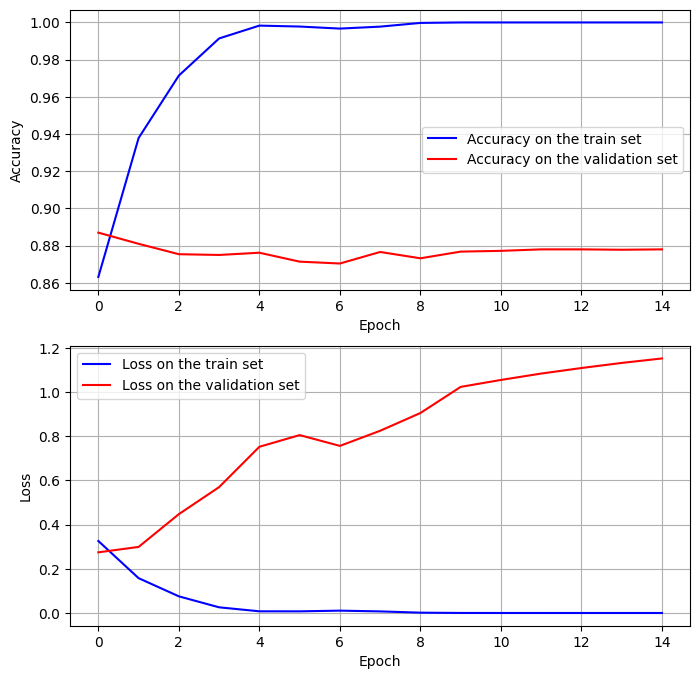

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_dense_ohe.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_dense_ohe.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_dense_ohe.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_dense_ohe.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Здесь видим явное переобучение модели. Для устранения эффекта переобучения используем метод `Dropout`.

Если наблюдается расхождение в точности выходных значений между обучающей и проверочной выборками, то процесс обучения следует остановить и уменьшить число нейронов.

Но это не всегда дает желаемые результаты. Не редко с уменьшением числа нейронов уменьшается и точность выходных значений, то есть, показатель качества работы нейросети ухудшается. Очевидно, в таких случаях с переобучением нужно бороться с сохранением числа нейронов. Здесь нам на помощь приходит алгоритм под названием Dropout

На русский язык его переводят как «метод прореживания» или «метод исключения» или же просто, говорят «дропаут».

Цель этого метода – снизить специализацию каждого отдельного нейрона и сделать из них «специалистов более широкого профиля». Именно в этом корень проблемы переобучения. Но как уменьшить специализацию, сохраняя прежнее число нейронов? Очень просто.

**на каждой итерации изменения весовых коэффициентов часть нейронов нужно исключать с заданной вероятностью `p`:**

**если веса меняются после каждого `mini-batch`, значит, переключение происходит после него. Если же веса меняются при каждом новом наблюдении, значит и переключение происходит с той же частотой. И так далее, то есть, мы переключаемся после каждой корректировки весовых коэффициентов.**

После того, как сеть обучена, включаются все нейроны и эффект переобучения (излишней специализации) должен заметно снизиться.

Во многих фреймворках алгоритм Dropout реализован именно так: суммарный сигнал на входах нейронов масштабируется, эмулируя поведение полной сети со всеми нейронами. Благодаря этому, в среднем, выходной сигнал сети соответствует истинным значениям и при ее эксплуатации (со всеми включенными нейронами) не будет возникать «сюрпризов».

Как выбирать значение вероятности `p`? Авторы этого подхода рекомендуют для нейронов скрытого слоя начинать со значения `p=0,5`. Затем при необходимости можно пробовать значения 0,4 и 0,3.

Также следует иметь в виду, что это не абсолютное средство: оно может как помочь, так и не помочь. Если эффекта нет, то от него лучше отказаться и искать другие пути выхода из сложившейся ситуации. И добавлять его в НС только в случае возникновения проблем с переобучением. Моя рекомендация: просто так сразу, изначально его применять не нужно, только при описанных проблемах.

Добавим в модель полносвязной НС слой `Dropuot` между скрытыми слоями и будем останавливать процесс обучения с помощью ранней остановки.

Создаем `EarlyStopping Callback`. Процесс обучения остановим, если на протяжении трех эпох функция потерь на валидационной выборке не уменьшается.

Повторим процесс обучения.

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=3, verbose=1)

In [ ]:
model_dense_ohe = keras.Sequential([
                          Dense(units = 128, input_shape = (max_words_count,), name = 'input', activation = 'relu'),
                          Dropout(0.5),
                          Dense(64, activation = 'relu'),
                          Dropout(0.5),
                          Dense(1, activation = 'sigmoid')
])


model_dense_ohe.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_dense_ohe.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
hist_dense_ohe = model_dense_ohe.fit(x_train_ohe, y_train, batch_size = 64, epochs = 15, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7533 - loss: 0.4861 - val_accuracy: 0.8912 - val_loss: 0.2718
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9210 - loss: 0.2133 - val_accuracy: 0.8864 - val_loss: 0.2774
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9495 - loss: 0.1403 - val_accuracy: 0.8876 - val_loss: 0.3057
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9685 - loss: 0.0879 - val_accuracy: 0.8868 - val_loss: 0.3493
Epoch 4: early stopping


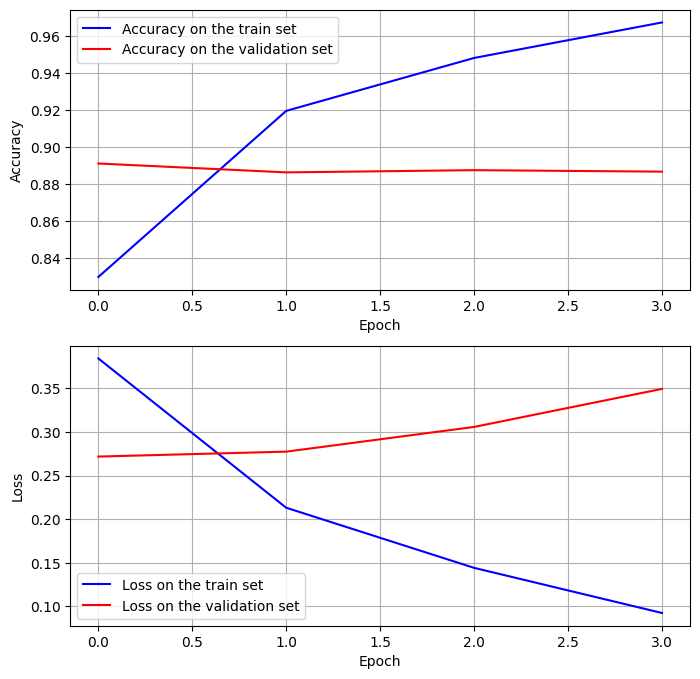

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_dense_ohe.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_dense_ohe.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_dense_ohe.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_dense_ohe.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Выполним проверку работы сети на тестовом множестве. Метод `evaluate` прогоняет все тестовое множество и вычисляет значение критерия качества и метрики.

In [ ]:
test_loss, test_accuracy = model_dense_ohe.evaluate(x_test_ohe, y_test)
print('Accuracy на тестовом наборе ', round(test_accuracy, 5))

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8712 - loss: 0.3775
Accuracy на тестовом наборе  0.8722


Удалось повысить качество классификации и снизить эффект переобучения.

### Embedding для представления текста

Построим и обучим нейронную сеть на основе вектора `Embedding`. Сформируем входной слой на основе вектора вложения фикированной длины.

In [ ]:
model_embedding = keras.Sequential([
    Embedding(input_dim = max_words_count, output_dim = 2, input_length=max_review_len),
    Dropout(0.25),
    Flatten(), #делают из матрицы вектор
    Dense(1, activation='sigmoid')
    ])

In [ ]:
# Компилируем модель
model_embedding.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Проводим обучение
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=3, verbose=1)
hist_embedding = model_embedding.fit(x_train_pad_seq, y_train, batch_size = 64, epochs = 15, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5259 - loss: 0.6906 - val_accuracy: 0.7210 - val_loss: 0.6275
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7638 - loss: 0.5610 - val_accuracy: 0.8364 - val_loss: 0.4111
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8573 - loss: 0.3671 - val_accuracy: 0.8658 - val_loss: 0.3370
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8891 - loss: 0.2945 - val_accuracy: 0.8624 - val_loss: 0.3183
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9042 - loss: 0.2567 - val_accuracy: 0.8800 - val_loss: 0.2962
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9113 - loss: 0.2295 - val_accuracy: 0.8830 - val_loss: 0.2887
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9210 - loss: 0.2114 - val_accuracy: 0.8698 - val_loss: 0.2990
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9287 - loss: 0.1965 - val_accuracy: 0.

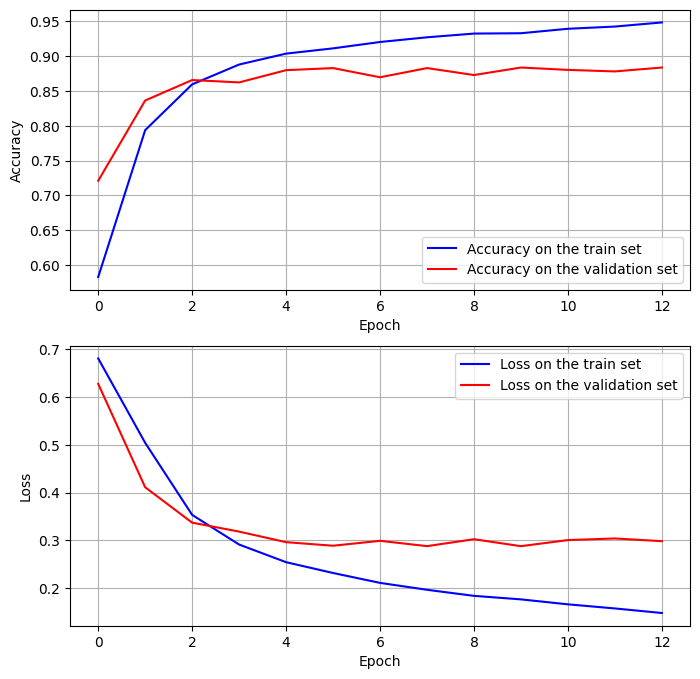

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_embedding.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_embedding.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_embedding.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_embedding.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Выполним проверку работы сети на тестовом множестве. Метод `evaluate` прогоняет все тестовое множество и вычисляет значение критерия качества и метрики.

In [ ]:
test_loss, test_accuracy = model_embedding.evaluate(x_test_pad_seq, y_test)
print('Accuracy на тестовом наборе ', round(test_accuracy, 5))

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8727 - loss: 0.3139
Accuracy на тестовом наборе  0.86748


Видим достаточно хорошее качество модели.

Исследуем обученное векторное представление слов. Для этого получим матрицу векторов embedding слов

In [ ]:
embedding_matrix = model_embedding.layers[0].get_weights()[0]
embedding_matrix[:10]

array([[-0.00625253, -0.00775631],
       [-0.10566384, -0.19915447],
       [-0.0129899 ,  0.05375217],
       [-0.03675099,  0.02441266],
       [ 0.05625443, -0.00822926],
       [ 0.10203953, -0.02477567],
       [ 0.00361425,  0.01810425],
       [-0.03377191,  0.00683285],
       [ 0.01471846, -0.02571982],
       [ 0.043624  , -0.0296289 ]], dtype=float32)

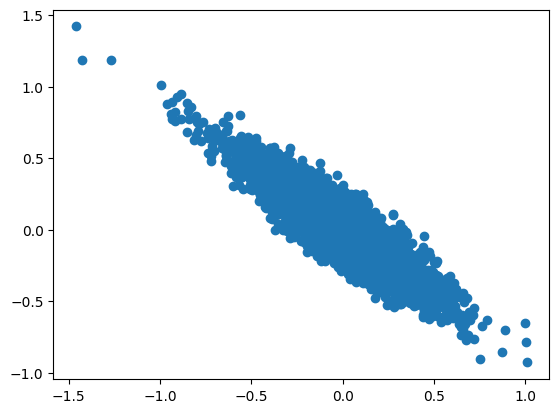

In [ ]:
# Визуализируем векторы embedding
plt.scatter(embedding_matrix[:,0], embedding_matrix[:,1])
plt.show()

Выбираем коды слов, по которым можно определить тональность отзыва

In [ ]:
review = ['brilliant', 'fantastic', 'like', 'amazing', 'good', 'never',
          'bad', 'awful','crap', 'terrible', 'trash']
enc_review = []
for word in review:
    enc_review.append(word_index[word])
enc_review

[527, 774, 37, 477, 49, 112, 75, 370, 592, 391, 1154]

In [ ]:
# Получаем векторное представление интересующих нас слов

review_vectors = embedding_matrix[enc_review]
review_vectors

array([[-0.8426163 ,  0.77450395],
       [ 0.07828321, -0.03674692],
       [ 0.001095  , -0.02078251],
       [ 0.0598343 , -0.01775744],
       [ 0.04293964,  0.03039926],
       [ 0.00446686, -0.0366523 ],
       [ 0.01404321,  0.07514946],
       [-0.22418287,  0.07691598],
       [-0.00665721,  0.01851583],
       [ 0.26281387, -0.12399555],
       [ 0.24363382, -0.1883139 ]], dtype=float32)

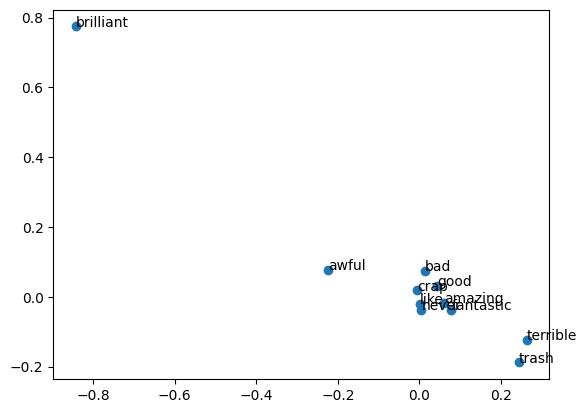

In [ ]:
# Визуализация обученного векторного представления слов, по которым можно определить эмоциональную окраску текста
plt.scatter(review_vectors[:,0], review_vectors[:,1])
for i, text in enumerate(review):
    plt.annotate(text, (review_vectors[i,0], review_vectors[i,1]))
plt.show()

## Рекуррентные нейронные сети

### SimpleRNN

Создадим модель простой рекуррентной сети, размерность выходного вектора - 8 нейронов.

In [ ]:
model_simple = keras.Sequential([
    Embedding(input_dim = max_words_count, output_dim = 2, input_length=max_review_len),
    SimpleRNN(units = 8),
    Dense(1, activation='sigmoid')
    ])
model_simple.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Компилируем и обучаем модель
model_simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Проводим обучение
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=3, verbose=1)
hist_simple = model_simple.fit(x_train_pad_seq, y_train, batch_size = 128, epochs = 15, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5091 - loss: 0.6935 - val_accuracy: 0.5046 - val_loss: 0.6921
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5518 - loss: 0.6866 - val_accuracy: 0.5190 - val_loss: 0.6869
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5854 - loss: 0.6649 - val_accuracy: 0.5230 - val_loss: 0.6860
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6178 - loss: 0.6291 - val_accuracy: 0.5186 - val_loss: 0.7153
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6617 - loss: 0.5797 - val_accuracy: 0.5208 - val_loss: 0.7342
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6944 - loss: 0.5357 - val_accuracy: 0.5202 - val_loss: 0.7841
Epoch 6: early stopping


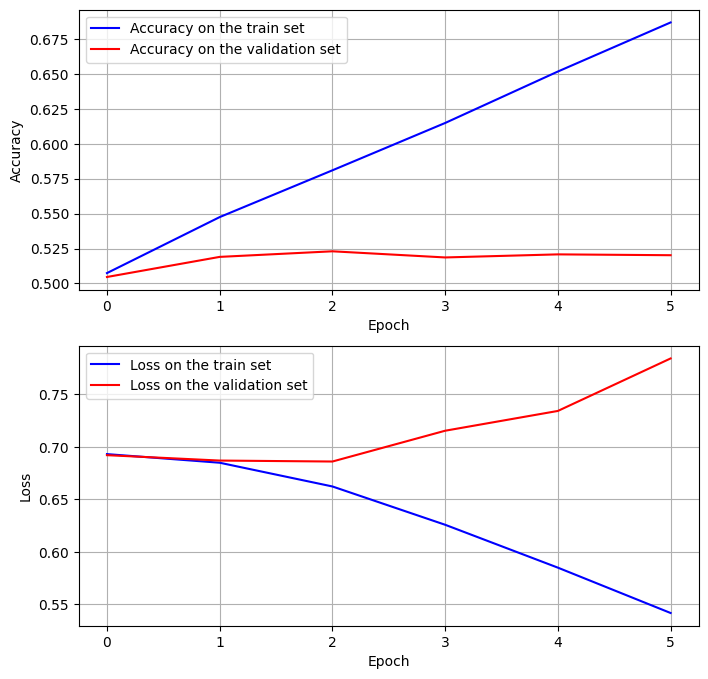

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_simple.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_simple.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_simple.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_simple.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Выполним проверку работы сети на тестовом множестве. Метод `evaluate` прогоняет все тестовое множество и вычисляет значение критерия качества и метрики.

In [ ]:
test_loss, test_accuracy = model_simple.evaluate(x_test_pad_seq, y_test)
print('Accuracy на тестовом наборе ', round(test_accuracy, 5))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5118 - loss: 0.7993
Accuracy на тестовом наборе  0.51416


Видим, что качество модели невысокое.

### GRU

Создадим модель рекуррентной сети GRU. В качестве первого параметра (`units`) указывается число нейронов в каждом полносвязном слое внутри GRU-ячейки. Они же будут формировать размерность выходного вектора. Например, создадим GRU-слой с 32 нейронами. Тогда размерность выходного вектора будет равна 32 элемента.

Чтобы избежать переобучения нужно контролировать этот эффект по выборке валидации и применять инструменты `Dropout` и `Batch Normalization` для его предотвращения.

В Keras `Dropout` можно использовать и для внутренних слоев ячеек, определяя следующие параметры классов `LSTM` и `GRU`:

* `dropout` – для нейронов, связанных с входным вектором ;
* `recurrent_dropout` – для нейронов, связанных с состоянием .

По умолчанию оба параметра равны нулю (`Dropout` отключен). Также можно использовать `Dropout` между рекуррентными слоями. Инструмент `Batch Normalization` используется только между слоями (внутри ячеек он не применяется).

In [ ]:
model_GRU = keras.Sequential([
    Embedding(input_dim = max_words_count, output_dim = 8, input_length=max_review_len),
    GRU(units = 32, recurrent_dropout = 0.2),
    Dense(1, activation='sigmoid')
    ])
model_GRU.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Компилируем и обучаем модель
model_GRU.compile(optimizer= 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Проводим обучение
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=3, verbose=1)
hist_GRU = model_GRU.fit(x_train_pad_seq, y_train, batch_size = 128, epochs = 15, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 445ms/step - accuracy: 0.5077 - loss: 65092.1328 - val_accuracy: 0.5164 - val_loss: 0.6861
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 70s 448ms/step - accuracy: 0.5236 - loss: 0.6796 - val_accuracy: 0.5686 - val_loss: 0.6789
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 433ms/step - accuracy: 0.5725 - loss: 0.6660 - val_accuracy: 0.5790 - val_loss: 0.6732
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 432ms/step - accuracy: 0.6162 - loss: 0.6499 - val_accuracy: 0.5834 - val_loss: 0.6674
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 85s 447ms/step - accuracy: 0.6274 - loss: 0.6369 - val_accuracy: 0.5824 - val_loss: 0.6628
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 433ms/step - accuracy: 0.6491 - loss: 0.6236 - val_accuracy: 0.5818 - val_loss: 0.6585
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 457ms/step - accuracy: 0.6543 - loss: 0.6112 - val_accuracy: 0.5820 - val_loss: 0.6561
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 429ms/step - accuracy: 0.6561 - los

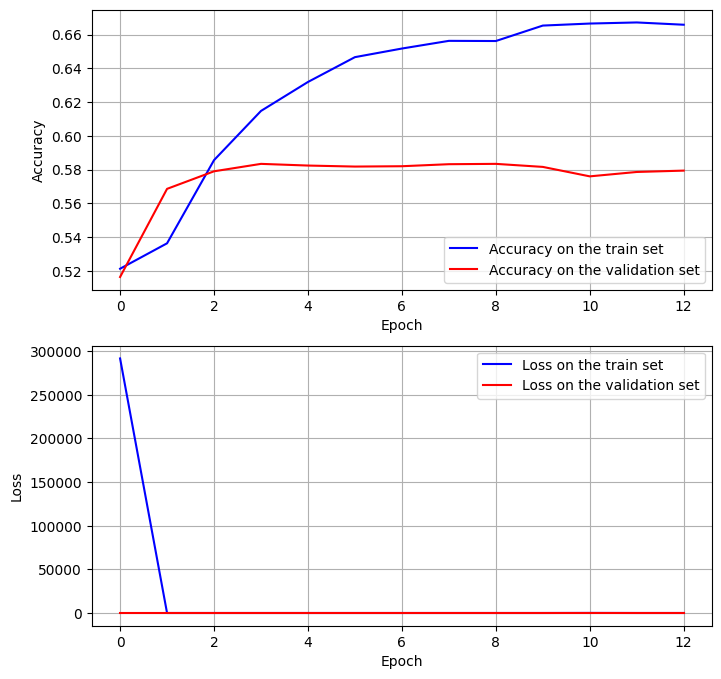

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_GRU.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_GRU.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_GRU.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_GRU.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Выполним проверку работы сети на тестовом множестве. Метод `evaluate` прогоняет все тестовое множество и вычисляет значение критерия качества и метрики.

In [ ]:
test_loss, test_accuracy = model_GRU.evaluate(x_test_pad_seq, y_test)
print('Accuracy на тестовом наборе ', round(test_accuracy, 5))

782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.5762 - loss: 0.6534
Accuracy на тестовом наборе  0.57036


Видим, что качество модели невысокое.

Добавьте еще один такой же рекуррентный слой с 32 нейронами. Тогда получится стек из двух рекуррентных слоев. Обратите внимание, что в этом случае первый рекуррентный блок должен вернуть последовательность, которая станет входным вектором следующего блока. Для этого укажите `return_sequences=True` при формировании первого рекуррентного блока `GRU`.

### LSTM

Создадим модель рекуррентной сети LSTM. В качестве первого параметра (`units`) указывается число нейронов в каждом полносвязном слое внутри LSTM-ячейки. Они же будут формировать размерность выходного вектора. Например, создадим LSTM-слой с 32 нейронами. Тогда размерность выходного вектора будет равна 32 элемента.



In [ ]:
model_LSTM = keras.Sequential([
    Embedding(input_dim = max_words_count, output_dim = 8, input_length=max_review_len),
    LSTM(units = 32, recurrent_dropout = 0.2),
    Dense(1, activation='sigmoid')
    ])
model_LSTM.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Компилируем и обучаем модель
model_LSTM.compile(optimizer= 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Проводим обучение
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience=3, verbose=1)
hist_LSTM = model_LSTM.fit(x_train_pad_seq, y_train, batch_size = 128, epochs = 15, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 117s 369ms/step - accuracy: 0.5239 - loss: 0.6911 - val_accuracy: 0.6696 - val_loss: 0.6084
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 158s 420ms/step - accuracy: 0.6135 - loss: 0.6620 - val_accuracy: 0.5792 - val_loss: 0.6623
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 122s 356ms/step - accuracy: 0.6433 - loss: 0.6194 - val_accuracy: 0.7756 - val_loss: 0.5394
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 343ms/step - accuracy: 0.7108 - loss: 0.5795 - val_accuracy: 0.6824 - val_loss: 0.6031
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 348ms/step - accuracy: 0.6931 - loss: 0.5740 - val_accuracy: 0.6234 - val_loss: 0.6237
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 138s 337ms/step - accuracy: 0.7019 - loss: 0.5485 - val_accuracy: 0.6204 - val_loss: 0.5622
Epoch 6: early stopping


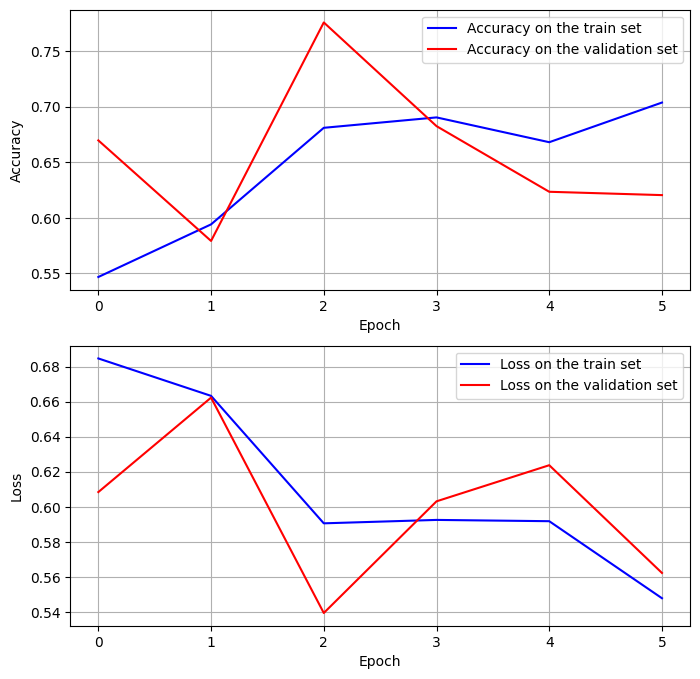

In [ ]:
# Кривые обучения
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(hist_LSTM.history['accuracy'], label='Accuracy on the train set', color = 'b')
plt.plot(hist_LSTM.history['val_accuracy'], label='Accuracy on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(hist_LSTM.history['loss'], label='Loss on the train set', color = 'b')
plt.plot(hist_LSTM.history['val_loss'], label='Loss on the validation set', color = 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Выполним проверку работы сети на тестовом множестве. Метод `evaluate` прогоняет все тестовое множество и вычисляет значение критерия качества и метрики.

In [ ]:
test_loss, test_accuracy = model_LSTM.evaluate(x_test_pad_seq, y_test)
print('Accuracy на тестовом наборе ', round(test_accuracy, 5))

782/782 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - accuracy: 0.6200 - loss: 0.5615
Accuracy на тестовом наборе  0.62
